In [1]:
import os
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img  # Correct import
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

In [7]:
TRAIN_DIR = '/kaggle/input/images/train'
TEST_DIR = '/kaggle/input/images/validation'
import os
print(os.listdir('/kaggle/input'))


['images']


In [8]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels

In [9]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

surprise completed
fear completed
angry completed
neutral completed
sad completed
disgust completed
happy completed


In [10]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

surprise completed
fear completed
angry completed
neutral completed
sad completed
disgust completed
happy completed


In [13]:
from tqdm.notebook import tqdm

In [14]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')  # Correct argument
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [15]:
train_features = extract_features(train['image']) 

  0%|          | 0/28821 [00:00<?, ?it/s]

In [16]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [17]:
x_train = train_features/255.0
x_test = test_features/255.0

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [22]:
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [23]:
y_train = to_categorical(y_train,num_classes = 7)
y_test = to_categorical(y_test,num_classes = 7)

In [42]:
from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Define the model
model = Sequential()
model.add(Input(shape=(48, 48, 1)))  

# First Conv Layer
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.01)) 
model.add(BatchNormalization())  # Adding BatchNormalization
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Second Conv Layer
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Third Conv Layer
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Fourth Conv Layer
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(7, activation='softmax'))

# Define optimizer with learning rate
learning_rate = 0.001  # Default learning rate for Adam optimizer
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with optimizer and learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler: Reduces the learning rate if the accuracy plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=128, callbacks=[lr_scheduler])


Epoch 1/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - accuracy: 0.2215 - loss: 2.1880 - val_accuracy: 0.2583 - val_loss: 2.0476 - learning_rate: 0.0010
Epoch 2/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.3974 - loss: 1.5630 - val_accuracy: 0.2501 - val_loss: 1.8261 - learning_rate: 0.0010
Epoch 3/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.4833 - loss: 1.3494 - val_accuracy: 0.3999 - val_loss: 1.6468 - learning_rate: 0.0010
Epoch 4/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5387 - loss: 1.2173 - val_accuracy: 0.5352 - val_loss: 1.2269 - learning_rate: 0.0010
Epoch 5/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5739 - loss: 1.1197 - val_accuracy: 0.5376 - val_loss: 1.1953 - learning_rate: 0.0010
Epoch 6/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.6010 - loss: 1.0555 - val_accuracy: 0.5579 - val_loss: 1.1646 - learning_rate: 0.0010
Epoch 7/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6270 - l

In [43]:
model_json = model.to_json()
with open("emotiondetector.json",'w') as json_file:
    json_file.write(model_json)
model.save("emotiondetector.h5")

In [44]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6026 - loss: 1.2232
Test accuracy: 0.6327483654022217


In [29]:
from keras.models import model_from_json

In [30]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [33]:
from keras.preprocessing.image import load_img
import numpy as np

def ef(image):
    img = load_img(image, color_mode='grayscale')  # Corrected argument
    feature = np.array(img)
    feature = feature.reshape(1, 48, 48, 1)  # Ensure the shape matches the model input
    feature = feature / 255.0  # Normalize the image if needed
    return feature


In [34]:
image = '/kaggle/input/images/train/sad/1010.jpg'  # Correct path
print("Original image is of sad")
img = ef(image)  # Call the updated ef function
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("Model prediction is", pred_label)


Original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Model prediction is sad


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
model prediction is  sad


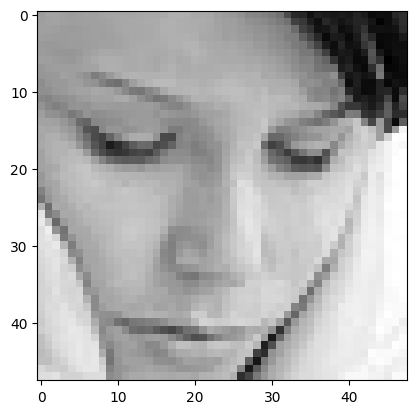

In [37]:
image = '/kaggle/input/images/train/sad/42.jpg' 
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

In [38]:
image = '/kaggle/input/face-expression-recognition-dataset/images/train/fear/10025.jpg' 
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of fear


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/face-expression-recognition-dataset/images/train/fear/10025.jpg'